In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [0]:
N_FACE = 70
N_POSE = 8

In [0]:
import json
import pandas as pd
import numpy as np
import os, os.path
import time
import csv

Reshape Data into Segments and Prepare for Keras (part5 data)

In [0]:
train_path = './drive/My Drive/636/dataset/part8/big/trainset.csv'
trainset = pd.read_csv(train_path, index_col=0)
test_path = './drive/My Drive/636/dataset/part8/big/testset.csv'
testset = pd.read_csv(test_path, index_col=0)

In [5]:
print(trainset.shape, testset.shape)

(128711, 159) (22722, 159)


In [0]:
# get number of features
N_FEATURES = (N_FACE + N_POSE) * 2

In [0]:
# slice every TIME_STEP frame as a segment until from 1st frame to last, if null, make up with 0
def get_slices(df, index_arr, TIME_STEP):
  slices = []
  for i in index_arr:
    if i + 1 < TIME_STEP:
      slice_ = df.values[df.index[0 : i + 1]]
      fillzero = np.zeros((TIME_STEP - i - 1, N_FEATURES))
      slice_ = np.concatenate((slice_, fillzero), axis=0)
      slices.append(slice_)
    else:
      slices.append(df.values[df.index[i + 1 - TIME_STEP : i + 1]])

  slices_arr = np.asarray(slices, dtype= np.float32)
  return slices_arr

In [0]:
def create_segments(df, TIME_STEP):
  # get video id
  vids = df.vid.unique()
  segments = []
  # get segment of each video id
  for i in vids:
    # slice every 10 frame as a segment and use the first label as label of segment
    # get all index of an id
    index_arr = df.index[df['vid'] == i]
    # drop the id and label
    df_s = df[df.columns[3:]]

    if i == vids[0]:
      segments = get_slices(df_s, index_arr, TIME_STEP)
    else:
      # get slices of each person
      segment = get_slices(df_s, index_arr, TIME_STEP)
      # print(i, segment.shape)
      segments = np.concatenate((segments, segment), axis=0)

  return segments

In [0]:
X_train = create_segments(trainset, 10)
X_test = create_segments(testset, 10)

In [0]:
y_train = trainset['label'].to_numpy()
y_test = testset['label'].to_numpy()

In [0]:
idx = np.random.permutation(y_train.shape[0])
X_train, y_train = X_train[idx], y_train[idx]

In [0]:
# draw
import matplotlib.pyplot as plt
def draw(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'b', label='Training acc', color='red')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')

  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss', color='red')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

Build model

In [13]:
%tensorflow_version 1.x
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, LSTM, CuDNNLSTM, Dropout, Flatten, Bidirectional, Conv1D, MaxPooling1D
from keras.callbacks import History, EarlyStopping, ModelCheckpoint

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 128
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156
# callbacks
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, 
                           verbose=2, mode='min')
callbacks_list = [early_stop, mcp_save]
model_path = './drive/My Drive/636/model/part8/'

Model 1

In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 128
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156
def create_model_1():
  model = Sequential()
  model.add(Dense(units = 128, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(LSTM(units = 128, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(LSTM(units = 64))
  model.add(Dropout(DROPOUT))

  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [0]:
# create model
model_1 = create_model_1()
history = model_1.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model_1.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10, 128)           20096     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 201,153
Trainable params:

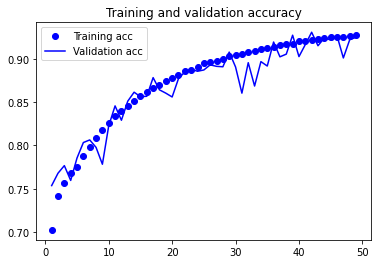

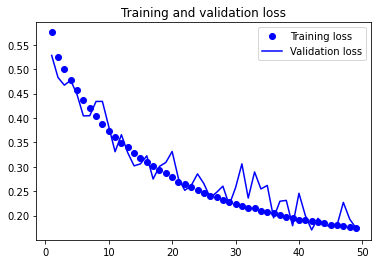

In [0]:
draw(history)

In [0]:
mkdir './drive/My Drive/636/model/part8/'

In [0]:
model_1.save('./drive/My Drive/636/model/part8/model1_6884.csv')

In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 128
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156
def create_model_1():
  model = Sequential()
  model.add(Dense(units = 64, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(LSTM(units = 64, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(LSTM(units = 32))
  model.add(Dropout(DROPOUT))

  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [0]:
# create model
model1_1 = create_model_1()
history = model1_1.fit(X_train, y_train, epochs=100, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model1_1.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 10, 64)            10048     
_________________________________________________________________
lstm_7 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 55,521
Trainable params: 55,521
Non-trainable params: 0
__________________________________________________

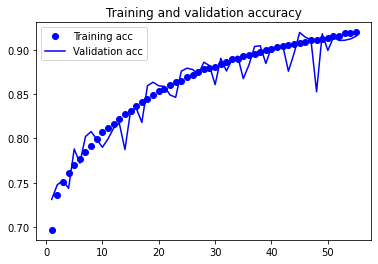

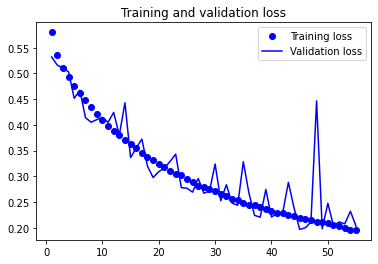

In [0]:
draw(history)

In [0]:
model_1.save('./drive/My Drive/636/model/part8/model1_7058.csv')

In [0]:
# create model
model1_2 = create_model_1()
history = model1_2.fit(X_train, y_train, epochs=100, batch_size=64, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model1_2.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score[0], "test acc: ", score[1])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 10, 64)            10048     
_________________________________________________________________
lstm_9 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 55,521
Trainable params: 55,521
Non-trainable params: 0
__________________________________________________

In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 64
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156
def create_model_2():
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                   input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [0]:
# create model
model2 = create_model_2()
history2 = model2.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score2 = model2.evaluate(X_test, y_test, verbose=2)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 9, 64)             20032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12850     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 32,933
Trainable params: 32,933
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 109404 samp

In [0]:
print("test loss: ", score2[0], "test acc: ", score2[1])

test loss:  4.156466325846713 test acc:  0.6522313356399536


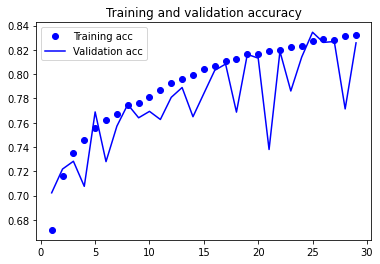

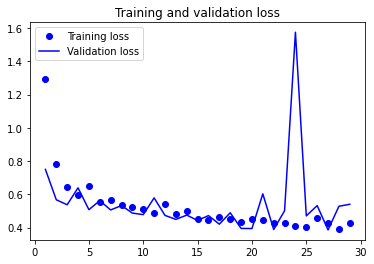

In [0]:
draw(history2)

In [0]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

def create_model_3():
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=128, kernel_size=4, activation='relu'), 
                            input_shape=(None, TIME_STEP, INPUT_DIM)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=4)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [0]:
# create model
model3 = create_model_3()
X_train_4 = X_train.reshape((X_train.shape[0], 1, TIME_STEP, INPUT_DIM))
history3 = model3.fit(X_train_4, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
X_test_4 = X_test.reshape((X_test.shape[0], 1, TIME_STEP, INPUT_DIM))
score3 = model3.evaluate(X_test_4, y_test, verbose=2)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, None, 7, 128)      80000     
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 1, 128)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 128)         0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 129,473
Trainable params: 129,473
Non-trainable params: 0
________________________________________________

In [0]:
print("test loss: ", score3[0], "test acc: ", score3[1])

test loss:  6.074319732047978 test acc:  0.6183874607086182


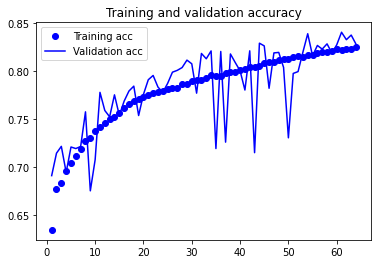

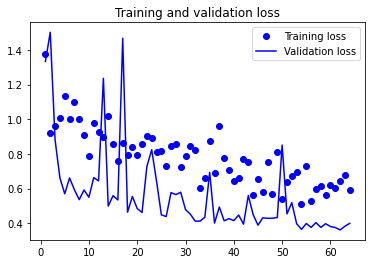

In [0]:
draw(history3)

In [0]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

def create_model_4():
  model = Sequential()
  model.add(Dense(units = 64, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(LSTM(64, activation='relu', input_shape=(TIME_STEP, INPUT_DIM), 
                 return_sequences = True))
  model.add(Dropout(0.5))
  model.add(LSTM(32, activation='relu'))
  model.add(Dropout(0.5)) 
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]
model4 = create_model_4()
history4 = model4.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score4 = model4.evaluate(X_test, y_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10, 64)            10048     
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 55,521
Trainable params: 55,521
Non-trainable params: 0
__________________________________________________

In [0]:
print("test loss: ", score4[0], "test acc: ", score4[1])

test loss:  56.53916373178726 test acc:  0.5278144478797913


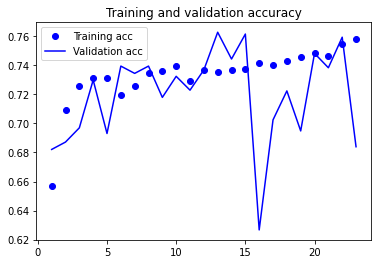

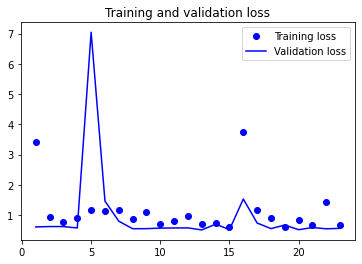

In [0]:
draw(history4)

In [0]:
def create_model_5():
  model = Sequential()
  model.add(Bidirectional(LSTM(64)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [0]:
model5 = create_model_5()
history5 = model5.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score5 = model5.evaluate(X_test, y_test, verbose=2)

Train on 102968 samples, validate on 25743 samples
Epoch 1/100
 - 37s - loss: 0.5731 - acc: 0.7018 - val_loss: 0.5821 - val_acc: 0.7106
Epoch 2/100
 - 36s - loss: 0.5250 - acc: 0.7382 - val_loss: 0.5105 - val_acc: 0.7456
Epoch 3/100
 - 36s - loss: 0.4986 - acc: 0.7548 - val_loss: 0.4865 - val_acc: 0.7696
Epoch 4/100
 - 36s - loss: 0.4725 - acc: 0.7696 - val_loss: 0.4576 - val_acc: 0.7812
Epoch 5/100
 - 36s - loss: 0.4506 - acc: 0.7829 - val_loss: 0.4468 - val_acc: 0.7815
Epoch 6/100
 - 36s - loss: 0.4347 - acc: 0.7915 - val_loss: 0.4227 - val_acc: 0.7942
Epoch 7/100
 - 37s - loss: 0.4199 - acc: 0.8004 - val_loss: 0.4107 - val_acc: 0.7971
Epoch 8/100
 - 38s - loss: 0.4069 - acc: 0.8073 - val_loss: 0.4693 - val_acc: 0.7924
Epoch 9/100
 - 38s - loss: 0.3945 - acc: 0.8138 - val_loss: 0.4039 - val_acc: 0.8116
Epoch 10/100
 - 37s - loss: 0.3850 - acc: 0.8205 - val_loss: 0.3754 - val_acc: 0.8260
Epoch 11/100
 - 37s - loss: 0.3778 - acc: 0.8246 - val_loss: 0.4155 - val_acc: 0.8118
Epoch 12/100

In [0]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 128)               113152    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 113,281
Trainable params: 113,281
Non-trainable params: 0
_________________________________________________________________


In [0]:
score5

[1.3158131882925275, 0.6402605175971985]

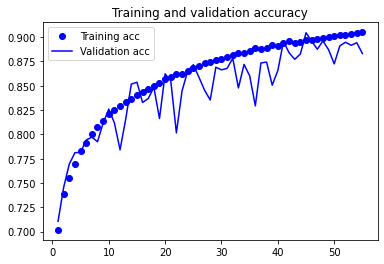

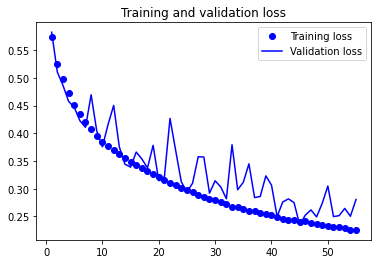

In [0]:
draw(history5)

In [0]:
def create_model5_1():
  model = Sequential()
  model.add(Bidirectional(LSTM(128)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

In [0]:
model5_1 = create_model5_1()
history5_1 = model5_1.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score5_1 = model5_1.evaluate(X_test, y_test, verbose=2)

Train on 102968 samples, validate on 25743 samples
Epoch 1/100
 - 105s - loss: 0.5706 - acc: 0.7038 - val_loss: 0.5519 - val_acc: 0.7089
Epoch 2/100
 - 99s - loss: 0.5213 - acc: 0.7417 - val_loss: 0.5150 - val_acc: 0.7352
Epoch 3/100
 - 98s - loss: 0.4904 - acc: 0.7602 - val_loss: 0.4698 - val_acc: 0.7853
Epoch 4/100
 - 98s - loss: 0.4668 - acc: 0.7733 - val_loss: 0.4755 - val_acc: 0.7644
Epoch 5/100
 - 103s - loss: 0.4470 - acc: 0.7853 - val_loss: 0.4284 - val_acc: 0.7956
Epoch 6/100
 - 98s - loss: 0.4264 - acc: 0.7953 - val_loss: 0.4699 - val_acc: 0.7699
Epoch 7/100
 - 98s - loss: 0.4105 - acc: 0.8049 - val_loss: 0.4408 - val_acc: 0.7879
Epoch 8/100
 - 98s - loss: 0.3943 - acc: 0.8134 - val_loss: 0.3908 - val_acc: 0.8251
Epoch 9/100
 - 98s - loss: 0.3775 - acc: 0.8254 - val_loss: 0.3845 - val_acc: 0.8171
Epoch 10/100
 - 98s - loss: 0.3636 - acc: 0.8328 - val_loss: 0.4125 - val_acc: 0.7989
Epoch 11/100
 - 103s - loss: 0.3540 - acc: 0.8396 - val_loss: 0.3784 - val_acc: 0.8301
Epoch 12/

In [0]:
score5_1

[2.1875940948089356, 0.5759176015853882]

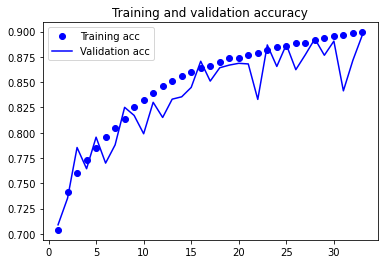

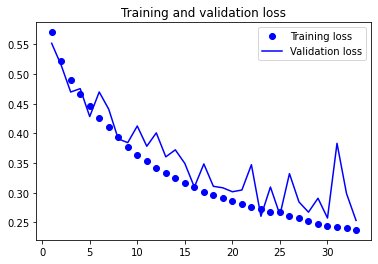

In [0]:
draw(history5_1)

In [0]:
def create_model5_2():
  model = Sequential()
  model.add(Bidirectional(LSTM(64, return_sequences = True)))
  model.add(Dropout(0.5))
  model.add(Bidirectional(LSTM(64)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [0]:
model5_2 = create_model5_2()
history5_2 = model5_2.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score5_2 = model5_2.evaluate(X_test, y_test, verbose=2)

Train on 102968 samples, validate on 25743 samples
Epoch 1/100
 - 80s - loss: 0.5711 - acc: 0.7022 - val_loss: 0.6060 - val_acc: 0.6846
Epoch 2/100
 - 78s - loss: 0.5238 - acc: 0.7396 - val_loss: 0.5185 - val_acc: 0.7345
Epoch 3/100
 - 78s - loss: 0.4947 - acc: 0.7574 - val_loss: 0.4741 - val_acc: 0.7763
Epoch 4/100
 - 82s - loss: 0.4679 - acc: 0.7724 - val_loss: 0.5006 - val_acc: 0.7472
Epoch 5/100
 - 78s - loss: 0.4437 - acc: 0.7878 - val_loss: 0.4196 - val_acc: 0.8002
Epoch 6/100
 - 78s - loss: 0.4259 - acc: 0.7975 - val_loss: 0.4967 - val_acc: 0.7630
Epoch 7/100
 - 77s - loss: 0.4117 - acc: 0.8061 - val_loss: 0.4291 - val_acc: 0.7858
Epoch 8/100
 - 77s - loss: 0.3999 - acc: 0.8147 - val_loss: 0.4044 - val_acc: 0.8035
Epoch 9/100
 - 77s - loss: 0.3859 - acc: 0.8223 - val_loss: 0.4132 - val_acc: 0.8155
Epoch 10/100
 - 77s - loss: 0.3760 - acc: 0.8275 - val_loss: 0.3664 - val_acc: 0.8326
Epoch 11/100
 - 79s - loss: 0.3664 - acc: 0.8331 - val_loss: 0.3766 - val_acc: 0.8162
Epoch 12/100

[1.0826131779391963, 0.6921926140785217]


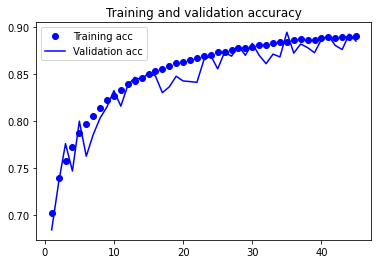

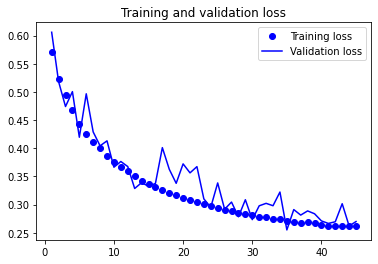

In [0]:
print(score5_2)
draw(history5_2)

In [0]:
model5_2.save('./drive/My Drive/636/model/part8/model5_6921.h5')

In [0]:
TIME_STEP = 10
BATCH_SIZE = 128
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156

In [0]:
# # fit and evaluate a model
# def create_model_6():
# 	model = Sequential()
# 	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(TIME_STEP, INPUT_DIM)))
# 	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# 	model.add(Dropout(0.5))
# 	model.add(MaxPooling1D(pool_size=2))
# 	model.add(Flatten())
# 	model.add(Dense(100, activation='relu'))
# 	model.add(Dense(1, activation='sigmoid'))
# 	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# 	return model

In [0]:
def create_model_6():
  model = Sequential()
  model.add(Dense(units = 64, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 64, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32, return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [0]:
# create model
model6 = create_model_6()
history6 = model6.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score6 = model6.evaluate(X_test, y_test, verbose=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10, 64)            10048     
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 10, 64)            33280     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 10, 32)            12544     
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 32)                8448      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [0]:
score6

[1.141565893992064, 0.664466142654419]

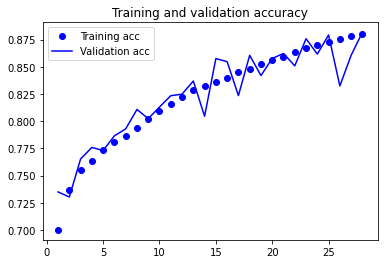

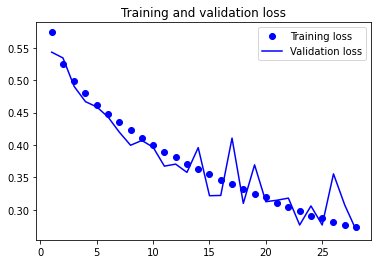

In [0]:
draw(history6)

In [0]:
model6.save(model_path + 'model6_6644.h5')

In [0]:
def create_model6_1():
  model = Sequential()
  model.add(Dense(units = 64, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 64, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32, return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dropout(DROPOUT))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [0]:
model6_1 = create_model_6()
history6_1 = model6_1.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score6_1 = model6_1.evaluate(X_test, y_test, verbose=2)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 10, 64)            10048     
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 10, 64)            33280     
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
cu_dnnlstm_11 (CuDNNLSTM)    (None, 10, 32)            12544     
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
cu_dnnlstm_12 (CuDNNLSTM)    (None, 32)                8448      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

[1.4973371101792676, 0.5671595931053162]


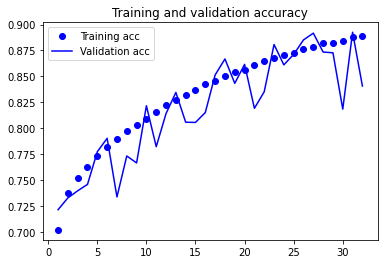

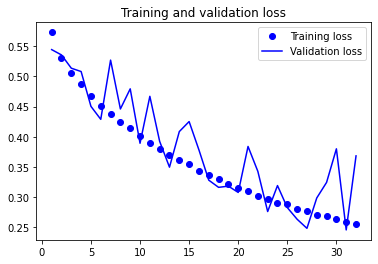

In [0]:
print(score6_1)
draw(history6_1)

In [0]:
model6_1.save(model_path + 'model6_1_5671.h5')

In [0]:
def create_model7():
  model = Sequential()
  model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu',
                    input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(MaxPooling1D(pool_size=4))
  model.add(CuDNNLSTM(64))
  model.add(Dropout(DROPOUT))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

In [0]:
model7 = create_model7()
history7 = model7.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score7 = model7.evaluate(X_test, y_test, verbose=2)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 256)           199936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 256)            0         
_________________________________________________________________
cu_dnnlstm_13 (CuDNNLSTM)    (None, 64)                82432     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 282,433
Trainable params: 282,433
Non-trainable params: 0
_________________________________________________________________
Train on 109404 samples, validate on 19307 samples
Epoch 1/100
 - 9s - loss: 0.5983 - acc: 0.6762 - val_loss: 0.5

[1.240389063208623, 0.6252970695495605]


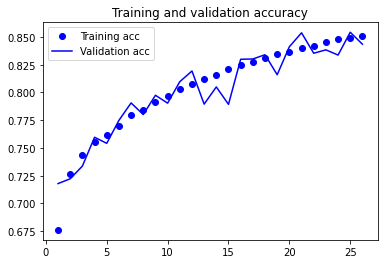

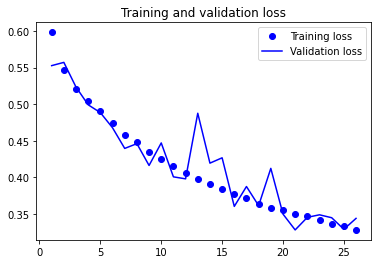

In [0]:
print(score7)
draw(history7)

In [0]:
model7.save('./drive/My Drive/636/model/part8/model7_6252.h5')

In [0]:
def create_model7_1():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu',
                    input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(MaxPooling1D(pool_size=4))
  model.add(CuDNNLSTM(64))
  model.add(Dropout(DROPOUT))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 10, 128)           99968     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
cu_dnnlstm_18 (CuDNNLSTM)    (None, 64)                49664     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 149,697
Trainable params: 149,697
Non-trainable params: 0
_________________________________________________________________
Train on 109404 samples, validate on 19307 samples
Epoch 1/100
 - 8s - loss: 0.5990 - acc: 0.6771 - val_loss: 0.57

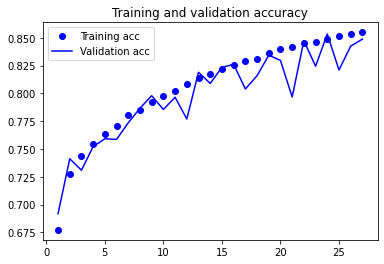

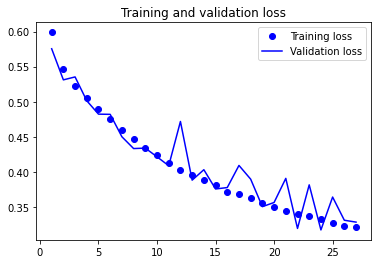

In [0]:
model7_1 = create_model7_1()
history7_1 = model7_1.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score7_1 = model7_1.evaluate(X_test, y_test, verbose=2)
print(score7_1)
draw(history7_1)

In [0]:
model7_1.save('./drive/My Drive/636/model/part8/model7_1_7037.h5')

In [0]:
def create_model8():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu',
                    input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(MaxPooling1D(pool_size=4))
  model.add(CuDNNLSTM(64, return_sequences=True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(32))
  model.add(Dropout(DROPOUT))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 10, 128)           99968     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
cu_dnnlstm_19 (CuDNNLSTM)    (None, 2, 64)             49664     
_________________________________________________________________
dropout_14 (Dropout)         (None, 2, 64)             0         
_________________________________________________________________
cu_dnnlstm_20 (CuDNNLSTM)    (None, 32)                12544     
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)               

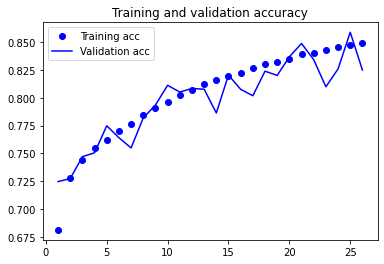

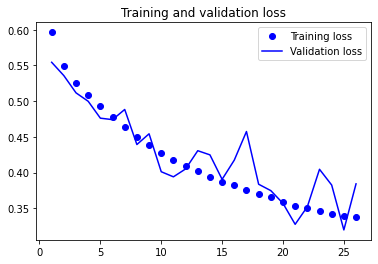

In [0]:
model8 = create_model8()
history8 = model8.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score8 = model8.evaluate(X_test, y_test, verbose=2)
print(score8)
draw(history8)

In [0]:
model8.save('./drive/My Drive/636/model/part8/model8_5856.h5')

In [0]:
from keras.utils import np_utils
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, Activation, MaxPooling1D, Dropout, Dense, LSTM, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint

In [0]:
def create_model9():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=2, activation='relu', 
                   input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(BatchNormalization())
  model.add(Activation("relu"))

  model.add(LSTM(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 9, 128)            40064     
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 128)            512       
_________________________________________________________________
activation_2 (Activation)    (None, 9, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 90,049
Trainable params: 89,793
Non-trainable params: 256
________________________________________________

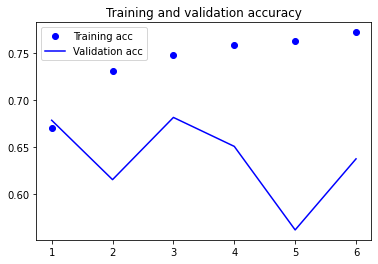

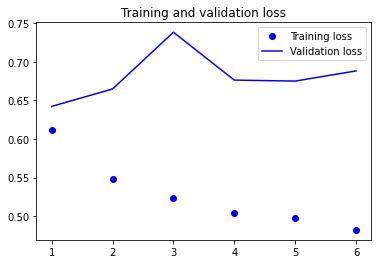

In [0]:
model9 = create_model9()
history9 = model9.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score9 = model9.evaluate(X_test, y_test, verbose=2)
print(score9)
draw(history9)

In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 128
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156
def create_model_10():
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                   input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 9, 64)             20032     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                12850     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 32,933
Trainable params: 32,933
Non-trainable params: 0
_________________________________________________________________
Train on 109404 samples, validate on 19307 samples
Epoch 1/100
 - 4s - loss: 1.1212 - acc: 0.6560 - val_loss: 0.6460

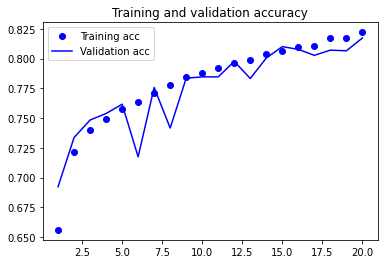

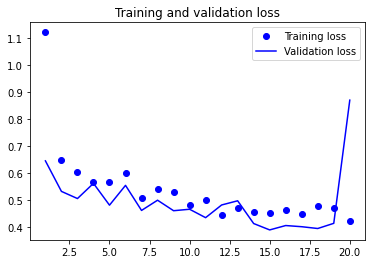

In [0]:
# create model
model10 = create_model_10()
history10 = model10.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score10 = model10.evaluate(X_test, y_test, verbose=2)
print(score10)
draw(history10)

In [0]:
model10.save(model_path + 'model10_6590.h5')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 9, 64)             20032     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 20,289
Trainable params: 20,289
Non-trainable params: 0
_________________________________________________________________
Train on 109404 samples, validate on 19307 samples
Epoch 1/100
 - 3s - loss: 2.3508 - acc: 0.6189 - val_loss: 2.7095 - val_acc: 0.5823
Epoch 2/100
 - 3s - loss: 1.5916 - acc: 0.6790 - val_loss: 0.5890 - val_acc: 0.7024
Epoch 3/100
 - 3s - loss: 0.6

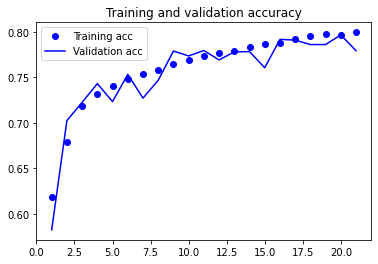

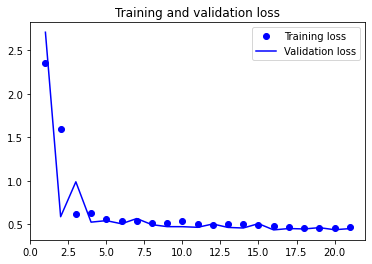

In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 128
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 156
def create_model_10():
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                   input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  # model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, 
                           verbose=2, mode='min')
callbacks_list = [early_stop]
# create model
model10 = create_model_10()
history10 = model10.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score10 = model10.evaluate(X_test, y_test, verbose=2)
print(score10)
draw(history10)

In [0]:
model10.save(model_path + 'model10_6364.h5')

In [0]:
X_train = X_train.reshape(X_train.shape[0], 40, 39, 1)
X_test = X_test.reshape(X_test.shape[0], 40, 39, 1)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
##designing the cnn
def create_model():
    #1st convolution layer
    model = Sequential()

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
    model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.8))

    #2nd convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.8))

    #3rd convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

    model.add(Flatten())

    #fully connected neural networks
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))
    # model.summary()

    #Compliling the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model


In [29]:
model_dropout8 = create_model()
model_dropout8.summary()
history_dropout8 = model_dropout8.fit(X_train, y_train, epochs=50, batch_size=128, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score_dropout8 = model_dropout8.evaluate(X_test, y_test, verbose=2)
print(score_dropout8)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 38, 37, 64)        640       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 36, 35, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 18, 17, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 18, 17, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 15, 64)        36928     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 14, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 6, 64)         

In [26]:
model_dropout = create_model()
model_dropout.summary()
history_dropout = model_dropout.fit(X_train, y_train, epochs=50, batch_size=128, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 38, 37, 64)        640       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 36, 35, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 17, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 18, 17, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 15, 64)        36928     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 6, 64)         

In [27]:
score_dropout = model_dropout.evaluate(X_test, y_test, verbose=2)
print(score_dropout)

[0.8432173577400096, 0.7508581876754761]


In [21]:
model_b = create_model()
model_b.summary()
history_b = model_b.fit(X_train, y_train, epochs=50, batch_size=128, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 38, 37, 64)        640       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 36, 35, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 17, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 18, 17, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 15, 64)        36928     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 6, 64)         

In [23]:
score_b = model_b.evaluate(X_test, y_test, verbose=2)
print(score_b)

[0.6477290755225208, 0.7586479783058167]


In [0]:
model_b.save(model_path + "big_7586.csv")

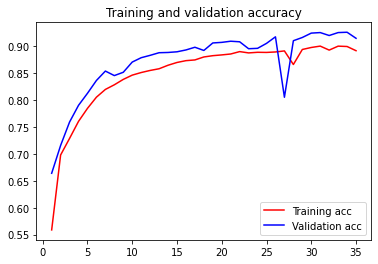

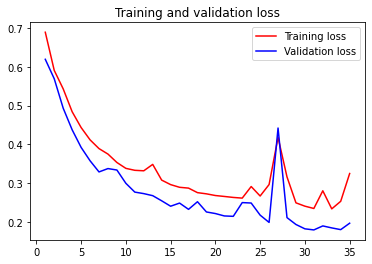

In [22]:
draw(history_b)

In [18]:
model_b = create_model()
model_b.summary()
history_b = model_b.fit(X_train, y_train, epochs=50, batch_size=256, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 38, 37, 64)        640       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 36, 35, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 17, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 18, 17, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 15, 64)        36928     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 6, 64)         

[0.901903670497259, 0.681762158870697]


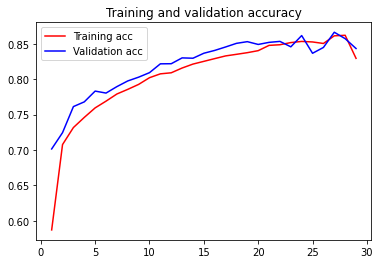

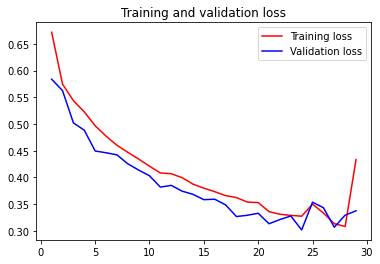

In [20]:
score_b = model_b.evaluate(X_test, y_test, verbose=2)
print(score_b)
draw(history_b)

[1.223253164772283, 0.746897280216217]


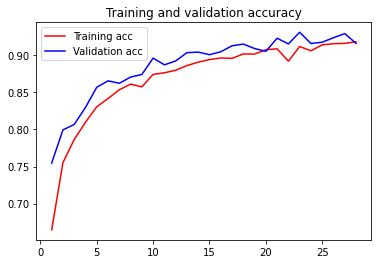

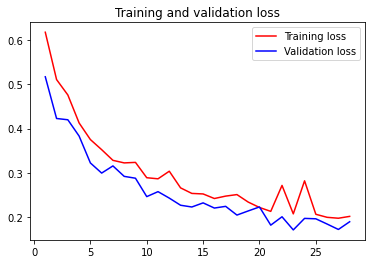

In [43]:
model = create_model()
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score = model.evaluate(X_test, y_test, verbose=2)
print(score)

Train on 109404 samples, validate on 19307 samples
Epoch 1/100
 - 37s - loss: 0.6278 - acc: 0.6707 - val_loss: 0.5520 - val_acc: 0.7308
Epoch 2/100
 - 37s - loss: 0.5484 - acc: 0.7293 - val_loss: 0.4936 - val_acc: 0.7573
Epoch 3/100
 - 37s - loss: 0.4752 - acc: 0.7735 - val_loss: 0.4578 - val_acc: 0.7701
Epoch 4/100
 - 37s - loss: 0.4745 - acc: 0.7818 - val_loss: 0.4203 - val_acc: 0.7983
Epoch 5/100
 - 37s - loss: 0.4210 - acc: 0.8019 - val_loss: 0.4001 - val_acc: 0.8154
Epoch 6/100
 - 37s - loss: 0.3959 - acc: 0.8171 - val_loss: 0.3667 - val_acc: 0.8307
Epoch 7/100
 - 37s - loss: 0.3775 - acc: 0.8278 - val_loss: 0.3736 - val_acc: 0.8315
Epoch 8/100
 - 37s - loss: 0.3547 - acc: 0.8393 - val_loss: 0.3350 - val_acc: 0.8446
Epoch 9/100
 - 37s - loss: 0.3534 - acc: 0.8462 - val_loss: 0.3490 - val_acc: 0.8536
Epoch 10/100
 - 37s - loss: 0.3767 - acc: 0.8441 - val_loss: 0.3213 - val_acc: 0.8567
Epoch 11/100
 - 37s - loss: 0.3237 - acc: 0.8564 - val_loss: 0.3055 - val_acc: 0.8628
Epoch 12/100

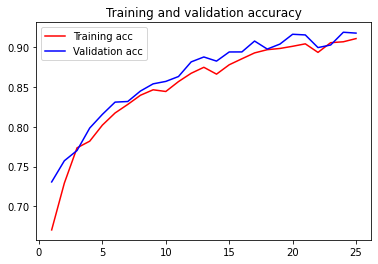

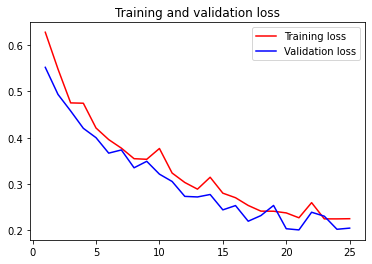

In [44]:
draw(history)

In [0]:
model.save(model_path + "big_7571.h5")

In [36]:
pwd

'/content'

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
##designing the cnn

def create_model_1(num_features):
    #1st convolution layer
    model = Sequential()

    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
    model.add(Conv2D(num_features,kernel_size= (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.5))

    # #2nd convolution layer
    # model.add(Conv2D(64, (3, 3), activation='relu'))
    # model.add(Conv2D(64, (3, 3), activation='relu'))
    # # model.add(BatchNormalization())
    # model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    # model.add(Dropout(0.5))

    #3rd convolution layer
    model.add(Conv2D(num_features * 4, (3, 3), activation='relu'))
    model.add(Conv2D(num_features * 4, (3, 3), activation='relu'))
    # model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())

    #fully connected neural networks
    model.add(Dense(num_features * 16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_features * 16, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))
    # model.summary()

    #Compliling the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model


Train on 109404 samples, validate on 19307 samples
Epoch 1/100
 - 32s - loss: 0.7083 - acc: 0.5536 - val_loss: 0.6782 - val_acc: 0.5565
Epoch 2/100
 - 31s - loss: 0.6750 - acc: 0.5657 - val_loss: 0.6746 - val_acc: 0.5623
Epoch 3/100
 - 31s - loss: 0.6713 - acc: 0.5706 - val_loss: 0.6691 - val_acc: 0.5694
Epoch 4/100
 - 31s - loss: 0.6681 - acc: 0.5771 - val_loss: 0.6398 - val_acc: 0.6152
Epoch 5/100
 - 31s - loss: 0.5755 - acc: 0.7025 - val_loss: 0.5458 - val_acc: 0.7294
Epoch 6/100
 - 31s - loss: 0.5593 - acc: 0.7174 - val_loss: 0.5292 - val_acc: 0.7373
Epoch 7/100
 - 31s - loss: 0.5549 - acc: 0.7272 - val_loss: 0.5131 - val_acc: 0.7461
Epoch 8/100
 - 31s - loss: 0.5279 - acc: 0.7323 - val_loss: 0.5085 - val_acc: 0.7502
Epoch 9/100
 - 31s - loss: 0.5128 - acc: 0.7390 - val_loss: 0.4919 - val_acc: 0.7513
Epoch 10/100
 - 31s - loss: 0.4989 - acc: 0.7443 - val_loss: 0.4898 - val_acc: 0.7533
Epoch 11/100
 - 31s - loss: 0.4788 - acc: 0.7622 - val_loss: 0.4790 - val_acc: 0.7799
Epoch 12/100

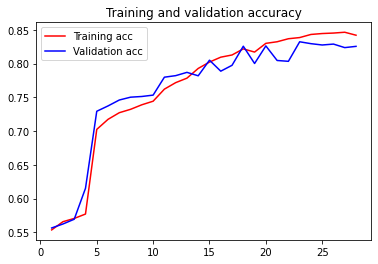

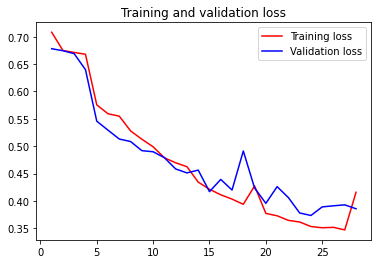

In [48]:
model_1 = create_model_1(39)
history_1 = model_1.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score_1 = model_1.evaluate(X_test, y_test, verbose=2)
print(score_1)
draw(history_1)

In [0]:
from keras.layers import SpatialDropout2D
from keras import regularizers

def create_model_4():
    model=Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(X_train.shape[1:])))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(0.5))


    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(SpatialDropout2D(0.5))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',kernel_regularizer=regularizers.l2(0.09)))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same',kernel_regularizer=regularizers.l2(0.09)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(0.5))
    model.add(Flatten())

    model.add(Dense(256,activation = 'relu',kernel_regularizer=regularizers.l2(0.09)))
    model.add(BatchNormalization())
    model.add(Dropout(0.7))
    model.add(Dense(256,activation = 'relu',kernel_regularizer=regularizers.l2(0.09)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1,activation = 'sigmoid'))
    #Compliling the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model


Train on 109404 samples, validate on 19307 samples
Epoch 1/100
 - 69s - loss: 4.5149 - acc: 0.5328 - val_loss: 0.8937 - val_acc: 0.5444
Epoch 2/100
 - 66s - loss: 0.8660 - acc: 0.6056 - val_loss: 0.9539 - val_acc: 0.5852
Epoch 3/100
 - 66s - loss: 0.8468 - acc: 0.6843 - val_loss: 0.8228 - val_acc: 0.7122
Epoch 4/100
 - 66s - loss: 0.8060 - acc: 0.7084 - val_loss: 0.7898 - val_acc: 0.7311
Epoch 5/100
 - 66s - loss: 0.7695 - acc: 0.7318 - val_loss: 0.7171 - val_acc: 0.7666
Epoch 6/100
 - 66s - loss: 0.7209 - acc: 0.7510 - val_loss: 0.7468 - val_acc: 0.7840
Epoch 7/100
 - 66s - loss: 0.6823 - acc: 0.7672 - val_loss: 0.6318 - val_acc: 0.8141
Epoch 8/100
 - 66s - loss: 0.6527 - acc: 0.7840 - val_loss: 0.6159 - val_acc: 0.8166
Epoch 9/100
 - 66s - loss: 0.6251 - acc: 0.7955 - val_loss: 0.5504 - val_acc: 0.8370
Epoch 10/100
 - 66s - loss: 0.6087 - acc: 0.8065 - val_loss: 0.5345 - val_acc: 0.8506
Epoch 11/100
 - 66s - loss: 0.5924 - acc: 0.8176 - val_loss: 0.5113 - val_acc: 0.8588
Epoch 12/100

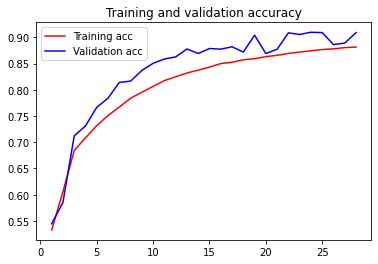

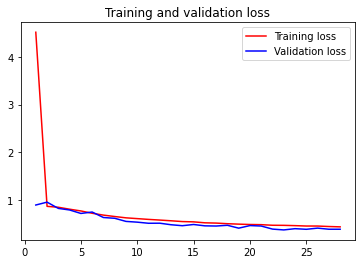

In [80]:
model_4 = create_model_4()
history_4 = model_4.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score_4 = model_4.evaluate(X_test, y_test, verbose=2)
print(score_4)
draw(history_4)

In [0]:
model_4.save(model_path + 'big_6189.h5')